In [224]:
import random
import pickle
import math
import scipy as sp
import scipy.stats as sps

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [225]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [226]:
model = SequenceModel(input_size=1578,
                      output_dim=1578,
                      hidden_size=128,
                      num_layers=1)

In [227]:
model.load_state_dict(torch.load( "ckpt/model.ckpt"))
model.eval()

SequenceModel(
  (lstm): LSTM(1578, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1578, bias=True)
)

In [228]:
with open("./ckpt/Z.pickle", "rb") as f:
    Z = pickle.load(f)
    
with open("./ckpt/scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
    
with open("./ckpt/multi_pdf.pickle", "rb") as f:
    multi_pdf = pickle.load(f)
    
    mean_vector = multi_pdf['mean_vector']
    covariance_inv = multi_pdf['covariance_inv']
    
    covariance = multi_pdf['covariance']
    covariance_det = multi_pdf['covariance_det']


In [229]:
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

In [230]:
var = sps.multivariate_normal(mean=mean_vector, cov=covariance)
    

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]),
 <a list of 9 Text yticklabel objects>)

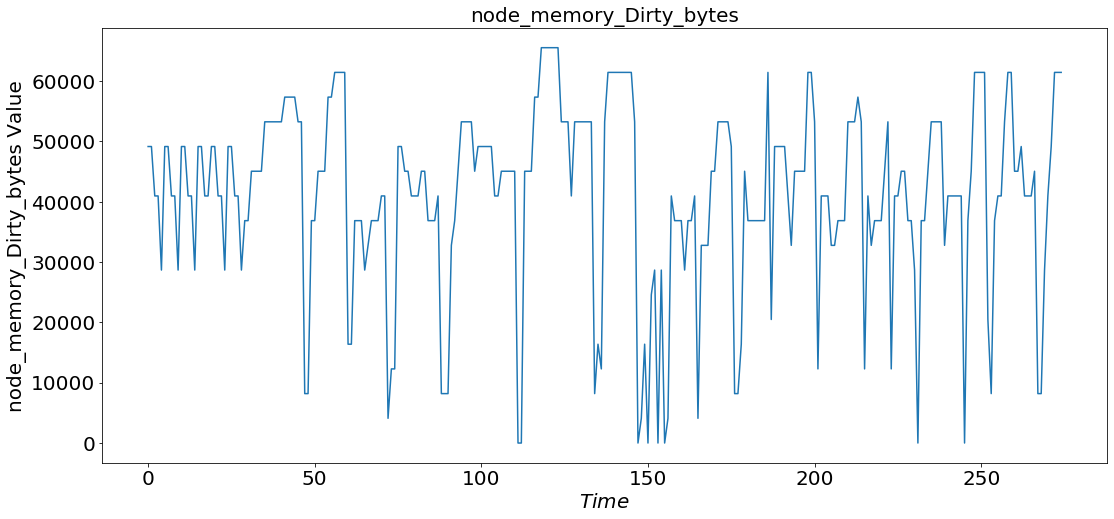

In [231]:
########### anomaly detection #################
#1) put the newdata into the model
plt.figure(figsize=(18,8))
normal_data  = pd.read_csv("./all_metric_sort_err.csv", sep=',', index_col=False)
data = normal_data['node_memory_Dirty_bytes'].to_numpy()

plt.plot(range(len(normal_data)), data, label="node_memory_Dirty_bytes")
plt.title("node_memory_Dirty_bytes", fontsize=20)
plt.xlabel("$Time$", fontsize=20)
plt.ylabel("node_memory_Dirty_bytes Value", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

In [232]:
def pseudo_function(x, x_i, n_data):
    n_wave = 5
    exp_max = 1
    exp_min = -1
    bias = 0.5
    a = 1.5
    
    radian_unit = (np.pi * n_wave) / n_data
    exp_unit = (exp_max - exp_min) / n_data 
    
    y = np.sin(x_i*radian_unit)* np.exp(exp_max-(exp_unit*x_i)) + bias#  + a*x
    
    return y

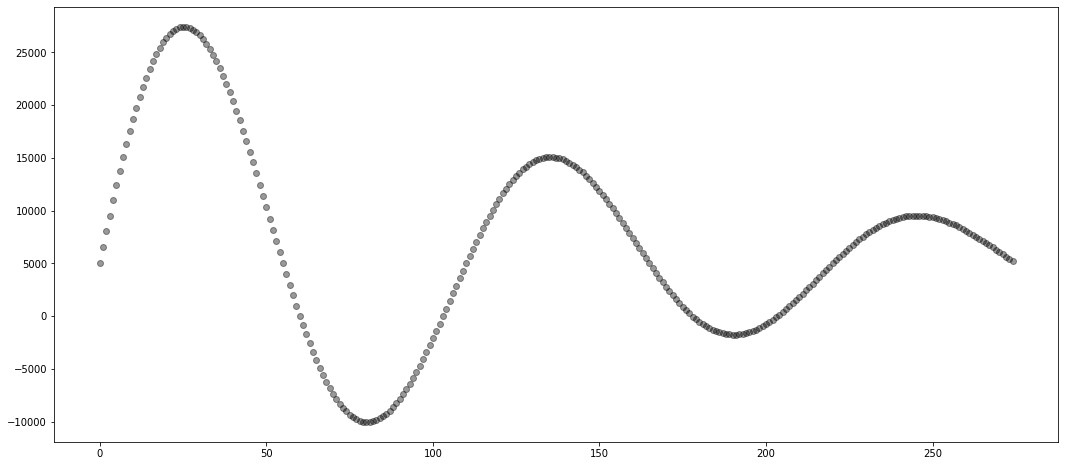

In [233]:
n_data = len(data)
x_range = (-1, 1)
plt.figure(figsize=(18,8))
X_noise = range(len(data))
Y_noise = np.array([pseudo_function(x,x_i,n_data) for x_i, x in enumerate(list(X_noise))], dtype=np.float32)

scale = 10000

Y_noise = Y_noise * scale

plt.plot(X_noise, Y_noise, 'ro', alpha=0.4, color='black')

In [234]:
#data_with_noise = data + Y_noise


data_with_noise = data.copy().astype("float")
data_with_noise[100:150] += Y_noise[100:150]


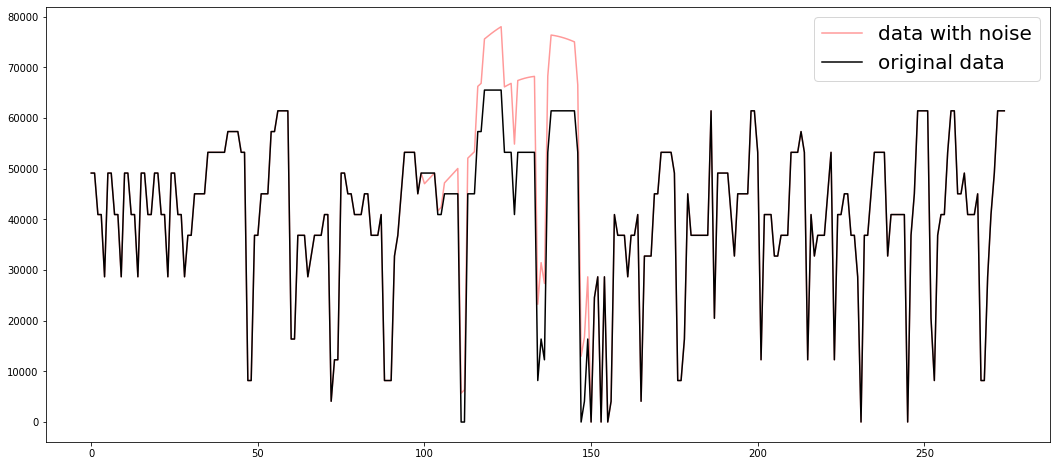

In [235]:
plt.figure(figsize=(18,8))
plt.plot(range(len(data_with_noise)), data_with_noise, 'r', alpha=0.4, color='Red', label="data with noise")
plt.plot(range(len(data)), data, 'r', alpha=1, color='black', label="original data")

plt.legend()

In [248]:
########### anomaly detection #################
#1) put the newdata into the model

newdata = pd.read_csv("./all_metric_sort_err.csv", sep=',', index_col=False)
forhead = pd.read_csv("./all_metric_sort_err.csv", sep=',', index_col=False)
headers = [h for h in newdata.keys() if not h.startswith('container_') and not h.startswith("go_") and not h.startswith("node_filesystem_") and h in forhead.keys()]
newdata = newdata[headers]
newdata['node_memory_Dirty_bytes'][120]

65536

In [246]:
newdata['node_memory_Dirty_bytes'] = data_with_noise

In [247]:
newdata['node_memory_Dirty_bytes'][120]

76676.2021484375

In [ ]:
newdata = newdata.to_numpy()
newdata = scaler.transform(newdata)


In [238]:

Z_newdata = []
window_size = 10
batch_size =192

reconstruction_error_new =[]
v_diff_list = []
anormal_score_list = []

for i in range(len(newdata) - window_size - 1):
    batch_input = newdata[i: i + window_size]
    batch_input = torch.tensor(batch_input, dtype=torch.float32).unsqueeze(0)
    new_v, new_z = model(batch_input)
    Z_newdata.append(new_z.detach().numpy())
    
    n_feature = new_v.shape[2]

    v_pred = new_v[:, :-1, :]  # 1 x (window_size-1) x n_feature
    
    v_gt = batch_input[:, 1:, :]
    
    v_diff = torch.abs(v_gt - v_pred) # 1 x (window_size-1) x n_feature
        
    v_diff = v_diff.mean(dim=1)  # 1 x n_feature
    
    # v_diff = torch.clamp(v_diff, -10, 10)
    
    v_diff = v_diff.detach().cpu().numpy()
    
    v_diff_list.append(v_diff)
    
    anormal_score = np.matmul(np.matmul((v_diff - mean_vector), covariance_inv), (v_diff - mean_vector).transpose())   # (1 x feature_dim) x (feature_dim x feature_dim) x (feature_dim x 1) 
    anormal_score = anormal_score.flatten()[0]
    # prob =  (1./ (np.power((2*np.pi), n_feature/2. ) *  np.power(covariance_det, 1./2. ) )) * np.exp( (-1./2.)*anormal_score)
    
    # anormal_score_list.append(anormal_score)
    
    # prob = sps.multivariate_normal.pdf(v_diff.flatten(), mean=mean_vector, cov=covariance)
    reconstruction_error_new.append(anormal_score)

In [239]:
mean_anormal = np.array(reconstruction_error_new).mean()
std_anormal =  np.array(reconstruction_error_new).std()

mean_data_newdata = np.array(data_with_noise).mean()
std_data_newdata =  np.array(data_with_noise).std()

orign_monitor = np.array(data).mean()
std_orignmonitor =  np.array(data).std()

In [240]:
data_with_noise.shape

(275,)

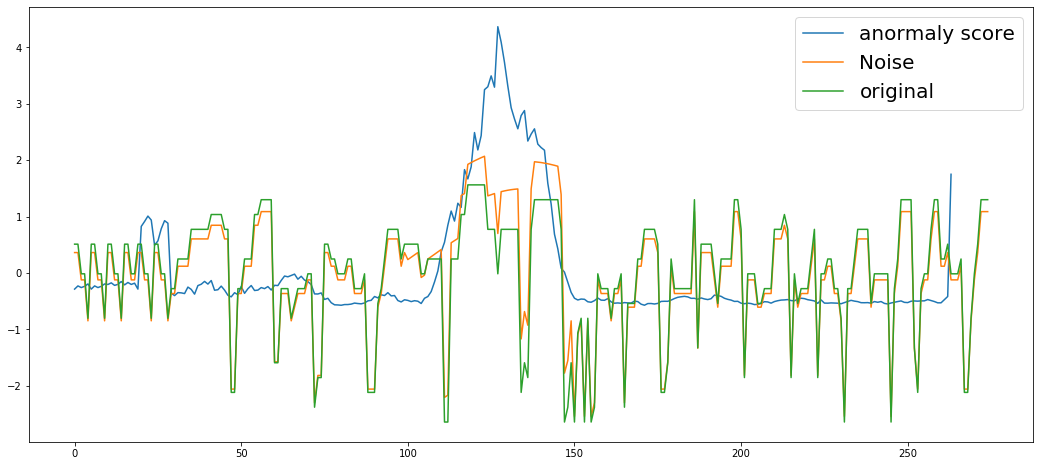

In [243]:

plt.figure(figsize=(18,8))
plt.rc('legend', fontsize=20)
plt.plot(range(len(reconstruction_error_new)), (np.array(reconstruction_error_new) - mean_anormal)/std_anormal, label="anormaly score")
plt.plot(range(len(data_with_noise)), (data_with_noise-mean_data_newdata)/std_data_newdata, label="Noise")
plt.plot(range(len(data)), (data-orign_monitor)/std_orignmonitor, label="original")


plt.legend()

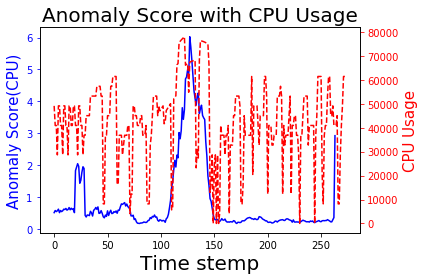

In [120]:



x1 = range(len(reconstruction_error_new))
x2 = range(len(monitor))
y1 = reconstruction_error_new
y2 = monitor


#plt.figure(figsize=(26,4))
ax1, ax2 = plt.gca(), plt.gca().twinx() 

ax1.plot(x1, y1, color='blue', linestyle='-')
ax1.set_ylabel('Anomaly Score(CPU)', color='blue', fontsize=15)
ax1.tick_params('y', colors='blue')
#plt.yscale('log')
ax2.plot(x2, y2, color='red', linestyle='--')
ax2.set_ylabel('CPU Usage', color='red', fontsize=15)
ax2.tick_params('y', colors='red')
plt.title("Anomaly Score with CPU Usage", fontsize=20)
ax1.set_xlabel("Time stemp", fontsize=20)
plt.tight_layout()
plt.show()